# 实验准备

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict, OrderedDict

import nltk
from nltk.tokenize import word_tokenize
from PIL import Image

from transformers import BertModel

In [2]:
nltk.download('punkt')

[nltk_data] Error loading punkt: [WinError 10060]
[nltk_data]     由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。


False

如果计算机安装有CUDA，则使用CUDA进行接下来的全部训练，否则使用CPU

In [3]:
# 如果计算机安装有CUDA，则使用CUDA进行接下来的全部训练，否则使用CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


根据训练数据查看文本的长度分布

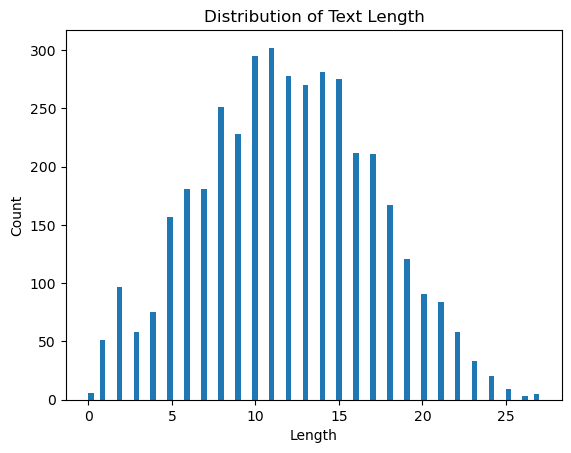

In [4]:
train_set_path = '../dataset/train.txt'
text_path = '../dataset/data/'

train_df = pd.read_csv(train_set_path, index_col=False)
guids = train_df['guid'].values

train_text = []
train_text_len = []

for guid in guids:
    path = text_path + str(guid) + '.txt'
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = [line.strip() for line in f.readlines() if line.strip()]  # 去除空行
    text = ' '.join(text)
        
    tokens = word_tokenize(text)  # 分词
    tokens = [word for word in tokens if word.isalpha()]  # 去除标点符号和数字
    tokens = [word.lower() for word in tokens]  # 转换为小写字母
    
    train_text.append(tokens)
    train_text_len.append(len(tokens))

plt.hist(train_text_len, bins=80)
plt.title('Distribution of Text Length')
plt.xlabel('Length')
plt.ylabel('Count')

fig_path = "../graph/Distribution of Text Length"
plt.savefig(fig_path)

根据训练数据建立词表

In [5]:
class Vocab:
    def __init__(self, text, min_freq=1, reserved_tokens=None):
        self.idx2token = list()
        self.token2idx = {}
        token_freqs = defaultdict(int)
        self.UNK_TOKEN = '<UNK>'
        
        for sentence in text:
            for token in sentence:
                token_freqs[token] += 1
                
        unique_tokens = [self.UNK_TOKEN]
        if reserved_tokens:
            unique_tokens += reserved_tokens
        # 过滤掉出现频率过低的词
        unique_tokens += [token for token, freq in token_freqs.items() if freq >= min_freq]

        for token in unique_tokens:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        self.unk = self.token2idx[self.UNK_TOKEN]

    def __len__(self):
        return len(self.idx2token)

    def __getitem__(self, token):
        return self.token2idx.get(token, self.unk)

    def convert_tokens_to_ids(self, tokens):
        return [self[token] for token in tokens]

    def convert_ids_to_tokens(self, ids):
        return [self.idx2token[idx] for idx in ids]

PAD_TOKEN = '<PAD>'
reserved_tokens = [PAD_TOKEN]
vocab = Vocab(train_text, reserved_tokens=reserved_tokens)

划分训练集、验证集、测试集，并转换为Dataloader对象

In [6]:
class SentimentDataset(Dataset):
    def __init__(self, dataframe, text_path, image_path, transform=None):
        self.guids = dataframe['guid'].values
        self.tags = dataframe['tag'].values
        self.text_path = text_path
        self.image_path = image_path
        self.transform = transform
        self.label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # 标签映射

    def __len__(self):
        return len(self.guids)

    def __getitem__(self, index):
        guid = self.guids[index]

        text_path = self.text_path + str(guid) + '.txt'
        with open(text_path, 'r', encoding='utf-8', errors='ignore') as f:
            text = [line.strip() for line in f.readlines() if line.strip()]  # 去除空行
        text = ' '.join(text)
        
        tokens = word_tokenize(text)  # 分词
        tokens = [word for word in tokens if word.isalpha()]  # 去除标点符号和数字
        tokens = [word.lower() for word in tokens]  # 转换为小写字母     
        ids = vocab.convert_tokens_to_ids(tokens)  # 利用词表进行转换
        ids = torch.tensor(ids, dtype=torch.long)

        image_path = self.image_path + str(guid) + '.jpg'
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        tag = self.tags[index]
        if pd.isna(tag):
            label = 3
        else:
            label = self.label_mapping[tag]

        return ids, image, label
    
def collate_fn(batch):
    text = [sample[0] for sample in batch]
    padded_text = pad_sequence(text, batch_first=True, padding_value=vocab[PAD_TOKEN])
    attention_mask = (padded_text != vocab[PAD_TOKEN]).type(torch.float32)
    
    images = torch.stack([sample[1] for sample in batch])
    
    labels = torch.tensor([sample[2] for sample in batch], dtype=torch.long)
    
    return padded_text, attention_mask, images, labels

train_set_path = '../dataset/train.txt'
test_set_path = '../dataset/test_without_label.txt'
text_path = '../dataset/data/'
image_path = '../dataset/data/'

# 读取训练数据
train_df = pd.read_csv(train_set_path, index_col=False)

# 将训练数据划分为训练集和验证集，固定划分（8:2）
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# 读取测试数据，即测试集
test_df = pd.read_csv(test_set_path, index_col=False)

num_train = train_df.shape[0]
num_val = val_df.shape[0]
num_test = test_df.shape[0]

print('X_train: ', num_train)
print('X_val: ', num_val)
print('X_test: ', num_test)
print()

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = SentimentDataset(train_df, text_path, image_path, image_transform)
val_dataset = SentimentDataset(val_df, text_path, image_path, image_transform)
test_dataset = SentimentDataset(test_df, text_path, image_path, image_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

X_train:  3200
X_val:  800
X_test:  511


查看Dataloader数据格式

In [7]:
for text, attention_mask, images, labels in train_loader:
    print(text[0])
    print(type(text[0]))
    print(attention_mask[0])
    print(type(attention_mask[0]))
    print(images[0])
    print(type(images[0]))
    print(labels[0])
    print(type(labels[0]))
    break

tensor([3720,  785, 1330, 3721, 3722,  889,   12,    3, 3723, 1734,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1])
<class 'torch.Tensor'>
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])
<class 'torch.Tensor'>
tensor([[[0.9451, 0.9451, 0.9451,  ..., 0.6941, 0.6863, 0.6745],
         [0.9451, 0.9451, 0.9451,  ..., 0.7294, 0.7098, 0.6902],
         [0.9451, 0.9451, 0.9451,  ..., 0.7059, 0.6824, 0.6627],
         ...,
         [0.7294, 0.7490, 0.7882,  ..., 0.2902, 0.1725, 0.0902],
         [0.6627, 0.6784, 0.7098,  ..., 0.5765, 0.5020, 0.2627],
         [0.6078, 0.6353, 0.6784,  ..., 0.2824, 0.4471, 0.3882]],

        [[0.9451, 0.9451, 0.9451,  ..., 0.6941, 0.6863, 0.6745],
         [0.9451, 0.9451, 0.9451,  ..., 0.7294, 0.7098, 0.6902],
         [0.9451, 0.9451, 0.9451,  ..., 0.7059, 0.6824, 0.6627],
         ...,
         [0.7294, 0.7490, 0.7882,  ..., 0.2902, 0.1725, 0.0902],
         [

# 训练并评价模型

定义文本分类模型

In [8]:
class TextRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded_text = self.embedding(text)
        rnn_output, _ = self.rnn(embedded_text)
        output = self.fc(rnn_output[:, -1, :])  # 使用最后一个隐藏层
        return output

class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded_text = self.embedding(text)
        rnn_output, _ = self.rnn(embedded_text)
        output = self.fc(rnn_output[:, -1, :])  # 使用最后一个隐藏层
        return output
    
class TextGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(TextGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded_text = self.embedding(text)
        rnn_output, _ = self.rnn(embedded_text)
        output = self.fc(rnn_output[:, -1, :])  # 使用最后一个隐藏层
        return output

class TextBERT(nn.Module):
    def __init__(self, output_dim):
        super(TextBERT, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', cache_dir='../model')
        self.fc = nn.Linear(self.bert.config.hidden_size, output_dim)

    def forward(self, text, attention_mask):
        outputs = self.bert(text, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.fc(pooled_output)
        return output

定义图像分类模型

In [9]:
class ImageAlexNet(nn.Module):
    def __init__(self, output_dim, dropout=0.0):
        super(ImageAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    
# 定义深度可分离卷积层
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride, dropout):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1,
                                        groups=in_channels, bias=False)
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)  # 添加Dropout层

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x

class ImageMobileNetV1(nn.Module):
    def __init__(self, output_dim, dropout=0.0):
        super(ImageMobileNetV1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(32, 64, stride=1, dropout=dropout),
            DepthwiseSeparableConv(64, 128, stride=2, dropout=dropout),
            DepthwiseSeparableConv(128, 128, stride=1, dropout=dropout),
            DepthwiseSeparableConv(128, 256, stride=2, dropout=dropout),
            DepthwiseSeparableConv(256, 256, stride=1, dropout=dropout),

            DepthwiseSeparableConv(256, 512, stride=2, dropout=dropout),
            DepthwiseSeparableConv(512, 512, stride=1, dropout=dropout),
            DepthwiseSeparableConv(512, 512, stride=1, dropout=dropout),
            DepthwiseSeparableConv(512, 512, stride=1, dropout=dropout),
            DepthwiseSeparableConv(512, 512, stride=1, dropout=dropout),

            DepthwiseSeparableConv(512, 1024, stride=2, dropout=dropout),
            DepthwiseSeparableConv(1024, 1024, stride=1, dropout=dropout),

            nn.AdaptiveAvgPool2d(1)
        )

        self.fc = nn.Linear(1024, output_dim)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

定义模态合并层（Merging Layer）

In [10]:
# 加法层（Sum Layer）
class SumLayer(nn.Module):
    def __init__(self):
        super(SumLayer, self).__init__()

    def forward(self, x1, x2):
        return x1 + x2
    

# 最大层（Maximum Layer）
class MaximumLayer(nn.Module):
    def __init__(self):
        super(MaximumLayer, self).__init__()

    def forward(self, x1, x2):
        return torch.max(x1, x2)


# 加权融合层（Weighted Ensemble Layer）
class WeightedEnsembleLayer(nn.Module):
    def __init__(self, input_dim):
        super(WeightedEnsembleLayer, self).__init__()
        self.weights = nn.Parameter(torch.rand(1, input_dim))  # 初始化权重

    def forward(self, x1, x2):
        weighted_sum = self.weights * x1 + (1 - self.weights) * x2
        return weighted_sum
    
 
# 拼接层（Concatenation Layer）   
class ConcatenationLayer(nn.Module):
    def __init__(self):
        super(ConcatenationLayer, self).__init__()

    def forward(self, x1, x2):
        return torch.cat((x1, x2), dim=1)

定义多模态分类模型

In [11]:
class MultimodalModel(nn.Module):
    def __init__(self, text_model_type, image_model_type, merging_layer_type, vocab_size, text_embed_dim, text_hidden_dim, num_classes):
        super(MultimodalModel, self).__init__()
        self.text_model_type = text_model_type
        self.image_model_type = image_model_type
        self.merging_layer_type = merging_layer_type
        
        if text_model_type == 'rnn':
            self.text_model = TextRNN(vocab_size, text_embed_dim, text_hidden_dim, num_classes)
        elif text_model_type == 'lstm':
            self.text_model = TextLSTM(vocab_size, text_embed_dim, text_hidden_dim, num_classes)
        elif text_model_type == 'gru':
            self.text_model = TextGRU(vocab_size, text_embed_dim, text_hidden_dim, num_classes)
        elif text_model_type == 'bert':
            self.text_model = TextBERT(num_classes)
            
        if image_model_type == 'alexnet':
            self.image_model = ImageAlexNet(num_classes)
        elif image_model_type == 'mobilenet':
            self.image_model = ImageMobileNetV1(num_classes)
        
        if merging_layer_type == 'Sum':
            self.merging = SumLayer()
        elif merging_layer_type == 'Maximum':
            self.merging = MaximumLayer()
        elif merging_layer_type == 'Weighted Ensemble':
            self.merging = WeightedEnsembleLayer(num_classes)
        elif merging_layer_type == 'Concatenation':
            self.merging = ConcatenationLayer()
            self.relu = nn.ReLU(inplace=True)
            self.fc = nn.Linear(2 * num_classes, num_classes)

    def forward(self, text, attention_mask, image):
        if self.text_model_type == 'bert':
            text_output = self.text_model(text, attention_mask)
        else:
            text_output = self.text_model(text)
        image_output = self.image_model(image)
        combined = self.merging(text_output, image_output)
        if self.merging_layer_type == 'Concatenation':
            combined = self.relu(combined)
            output = self.fc(combined)
        else:
            output = combined
        return output

检查模型准确率

In [12]:
def check_accuracy(model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for text, attention_mask, images, labels in val_loader:
            text = text.to(device)
            attention_mask = attention_mask.to(device)
            images = images.to(device)
            labels = labels.to(device)
            scores = model(text, attention_mask, images)
            _, preds = scores.max(1)
            num_correct += (preds == labels).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

训练模型

In [13]:
def train_model(model, optimizer, epochs):
    model.to(device)
    model.train()
    
    train_loss = []
    for epoch in range(epochs):
        total_loss = 0
        for text, attention_mask, images, labels in train_loader:
            # 将待更新参数的梯度置为零
            optimizer.zero_grad()
            
            text = text.to(device)
            attention_mask = attention_mask.to(device)
            images = images.to(device)
            labels = labels.to(device)

            scores = model(text, attention_mask, images)
            
            loss = F.cross_entropy(scores, labels)

            # 反向传播，计算梯度
            loss.backward()

            # 利用梯度更新参数
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_train
        print(f'Epoch: {epoch + 1}/{epochs}')
        print(f'Train Loss: {avg_loss}')
        train_loss.append(avg_loss)
        
    val_acc = check_accuracy(model)
    
    return model, train_loss, val_acc

记录训练损失

In [14]:
train_loss_all = dict()

使用RNN/AlexNet作为文本模型/图像模型组合

In [15]:
best_model = None
best_merging_layer = None
best_val_acc = -1

learning_rate = 5e-4
vocab_size = len(vocab)
text_embed_dim = 256
text_hidden_dim = 512
num_classes = 3

text_model_type = 'rnn'
image_model_type = 'alexnet'
merging_layer_types = ['Sum', 'Maximum', 'Weighted Ensemble', 'Concatenation']

for merging_layer_type in merging_layer_types:
    model = MultimodalModel(text_model_type, image_model_type, merging_layer_type, vocab_size, text_embed_dim, text_hidden_dim, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model, train_loss, val_acc = train_model(model, optimizer, epochs=30)
    train_loss_all[merging_layer_type] = train_loss
    if val_acc > best_val_acc:
        # best_model = model
        best_val_acc = val_acc
        best_merging_layer = merging_layer_type
    print('text_model %s image_model %s merging_layer %s val accuracy: %f' % (text_model_type,image_model_type, merging_layer_type, val_acc))
    
print('best validation accuracy achieved:')
print('text_model %s image_model %s merging_layer %s val accuracy: %f' % (text_model_type, image_model_type, best_merging_layer, best_val_acc))
# text_model rnn image_model alexnet merging_layer Concatenation val accuracy: 0.607500

Epoch: 1/30
Train Loss: 0.014652967844158411
Epoch: 2/30
Train Loss: 0.014312815442681313
Epoch: 3/30
Train Loss: 0.014426884576678276
Epoch: 4/30
Train Loss: 0.014133120756596326
Epoch: 5/30
Train Loss: 0.014076541010290385
Epoch: 6/30
Train Loss: 0.013937771543860436
Epoch: 7/30
Train Loss: 0.01393686231225729
Epoch: 8/30
Train Loss: 0.013830373827368021
Epoch: 9/30
Train Loss: 0.01373139364644885
Epoch: 10/30
Train Loss: 0.013616576995700598
Epoch: 11/30
Train Loss: 0.013573605883866548
Epoch: 12/30
Train Loss: 0.013524452056735754
Epoch: 13/30
Train Loss: 0.013464659433811903
Epoch: 14/30
Train Loss: 0.013310348503291608
Epoch: 15/30
Train Loss: 0.013281267676502466
Epoch: 16/30
Train Loss: 0.013481890186667442
Epoch: 17/30
Train Loss: 0.013185327090322971
Epoch: 18/30
Train Loss: 0.01275961685925722
Epoch: 19/30
Train Loss: 0.012450602240860462
Epoch: 20/30
Train Loss: 0.012139016389846801
Epoch: 21/30
Train Loss: 0.012065277472138404
Epoch: 22/30
Train Loss: 0.011884506177157163


使用GRU/MobileNet作为文本模型/图像模型组合

In [16]:
best_model = None
best_merging_layer = None
best_val_acc = -1

learning_rate = 5e-4
vocab_size = len(vocab)
text_embed_dim = 256
text_hidden_dim = 512
num_classes = 3

text_model_type = 'gru'
image_model_type = 'mobilenet'
merging_layer_types = ['Sum', 'Maximum', 'Weighted Ensemble', 'Concatenation']

for merging_layer_type in merging_layer_types:
    model = MultimodalModel(text_model_type, image_model_type, merging_layer_type, vocab_size, text_embed_dim, text_hidden_dim, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model, train_loss, val_acc = train_model(model, optimizer, epochs=30)
    train_loss_all[merging_layer_type] = train_loss
    if val_acc > best_val_acc:
        # best_model = model
        best_val_acc = val_acc
        best_merging_layer = merging_layer_type
    print('text_model %s image_model %s merging_layer %s val accuracy: %f' % (text_model_type,image_model_type, merging_layer_type, val_acc))
    
print('best validation accuracy achieved:')
print('text_model %s image_model %s merging_layer %s val accuracy: %f' % (text_model_type, image_model_type, best_merging_layer, best_val_acc))
# text_model gru image_model mobilenet merging_layer Maximum val accuracy: 0.617500

Epoch: 1/30
Train Loss: 0.014941926430910826
Epoch: 2/30
Train Loss: 0.013354929517954589
Epoch: 3/30
Train Loss: 0.00996671718545258
Epoch: 4/30
Train Loss: 0.004813272699248045
Epoch: 5/30
Train Loss: 0.002942984888795763
Epoch: 6/30
Train Loss: 0.0015851007192395627
Epoch: 7/30
Train Loss: 0.0011453656427329406
Epoch: 8/30
Train Loss: 0.0007427566559636034
Epoch: 9/30
Train Loss: 0.000649111288075801
Epoch: 10/30
Train Loss: 0.0004059235486056423
Epoch: 11/30
Train Loss: 0.0003396608457478578
Epoch: 12/30
Train Loss: 0.0003274822329694871
Epoch: 13/30
Train Loss: 0.00030430202412389917
Epoch: 14/30
Train Loss: 0.0002735846696668887
Epoch: 15/30
Train Loss: 0.00024880299204596665
Epoch: 16/30
Train Loss: 0.0002353333926475898
Epoch: 17/30
Train Loss: 0.00020506256535554712
Epoch: 18/30
Train Loss: 0.00020013394392663032
Epoch: 19/30
Train Loss: 0.00019691657458679402
Epoch: 20/30
Train Loss: 0.00020611002782061405
Epoch: 21/30
Train Loss: 0.00019043442831389256
Epoch: 22/30
Train Los

预测测试集的标签并补全保存

In [ ]:
def predict(model):
    all_preds = []
    
    model.eval()
    with torch.no_grad():
        for text, attention_mask, images, labels in test_loader:
            text = text.to(device)
            attention_mask = attention_mask.to(device)
            images = images.to(device)
            scores = model(text, attention_mask, images)
            _, preds = scores.max(1)
            all_preds.append(preds.cpu().numpy())
            
    tag = np.concatenate(all_preds)
    label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}  # 标签映射
    tag_mapping = []
    for i in range(len(tag)):
        tag_mapping.append(label_mapping[tag[i]])
    
    test_df = pd.read_csv(test_set_path, index_col=False)
    test_df['tag'] = tag
    result_path = '../result/result_late_fusion.txt'
    test_df.to_csv(result_path, index=False)

In [ ]:
predict(model)

# 绘制图像

In [16]:
# 绘制训练损失变化图
def plot_train_loss(train_loss, title, path):
    merging_methods = ['Sum', 'Maximum', 'Weighted Ensemble', 'Concatenation']
    epoch = np.arange(1, 31)
    
    for i in range(len(merging_methods)):
        plt.plot(epoch, train_loss[merging_methods[i]], label=merging_methods[i])
    
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.savefig(path)

In [24]:
# 绘制各模型在验证集上的预测准确率图
def plot_val_acc(acc_values, title, path):    
    merging_methods = ['Sum', 'Maximum', 'Weighted Ensemble', 'Concatenation']
    
    acc_mean = np.mean(acc_values, axis=1)
    acc_std = np.std(acc_values, axis=1)
    plt.errorbar(merging_methods, acc_mean, yerr=acc_std, fmt='o-')
    
    plt.xlabel('Merging Method')
    plt.ylabel('Validation Accuracy')
    plt.title(title)
    plt.savefig(path, bbox_inches='tight')

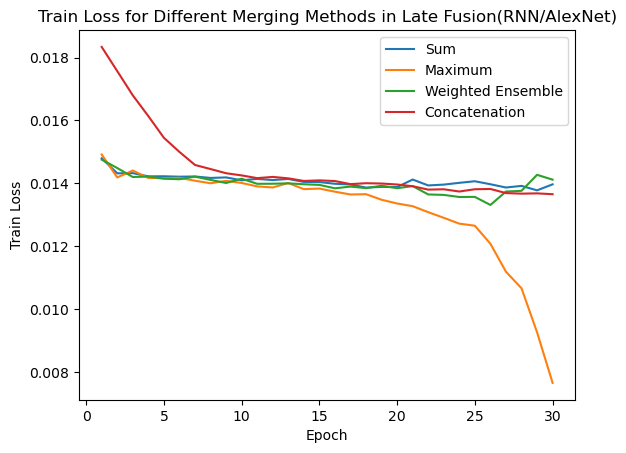

In [18]:
title1 = "Train Loss for Different Merging Methods in Late Fusion(RNN/AlexNet)"
fig1_path = "../graph/Train Loss for Different Merging Methods in Late Fusion(RNN AlexNet).png"
plot_train_loss(train_loss_all, title1, fig1_path)

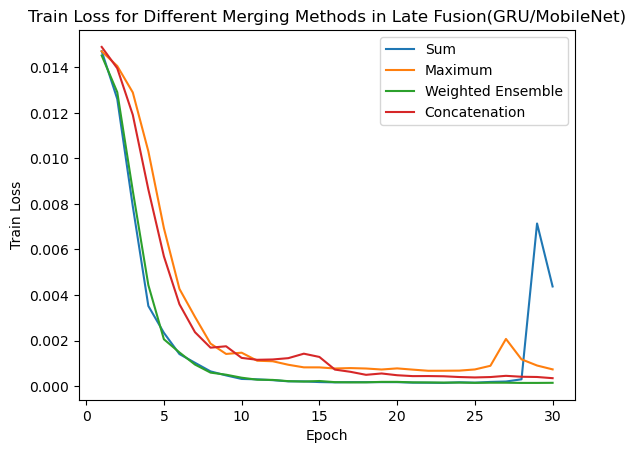

In [20]:
title2 = "Train Loss for Different Merging Methods in Late Fusion(GRU/MobileNet)"
fig2_path = "../graph/Train Loss for Different Merging Methods in Late Fusion(GRU MobileNet).png"
plot_train_loss(train_loss_all, title2, fig2_path)

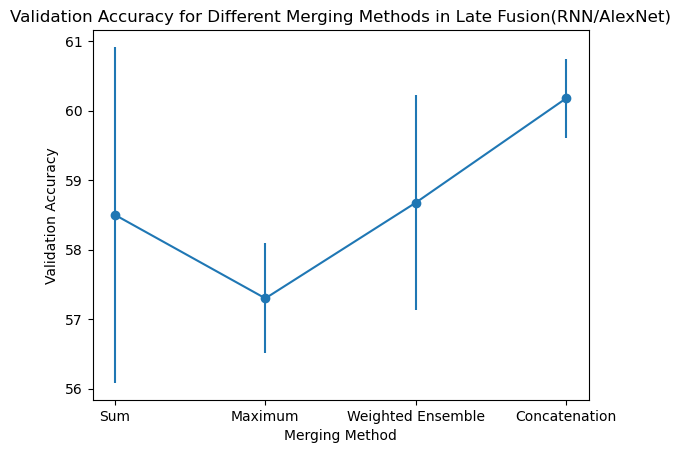

In [25]:
val_acc_values = np.array([[60.500, 59.875, 59.875, 58.375, 53.875],
                           [56.875, 58.750, 56.875, 57.500, 56.500],
                           [60.625, 57.125, 60.250, 56.875, 58.500],
                           [60.375, 60.750, 60.125, 59.125, 60.500]])

title3 = "Validation Accuracy for Different Merging Methods in Late Fusion(RNN/AlexNet)"
fig3_path = "../graph/Validation Accuracy for Different Merging Methods in Late Fusion(RNN AlexNet).png"
plot_val_acc(val_acc_values, title3, fig3_path)

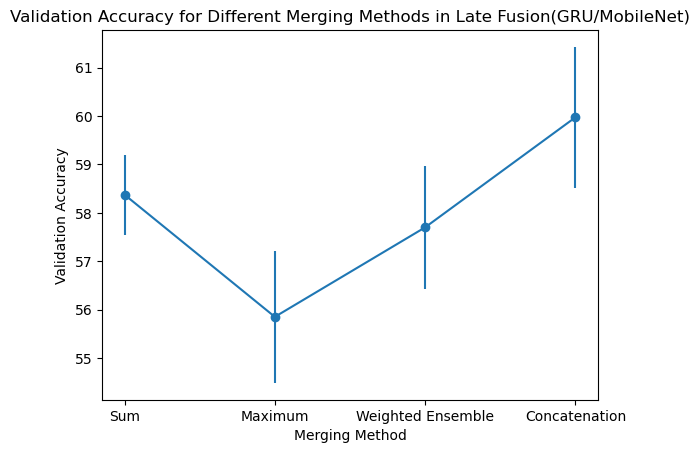

In [26]:
val_acc_values = np.array([[58.500, 59.875, 57.625, 57.625, 58.250],
                           [57.000, 57.375, 56.375, 54.625, 53.875],
                           [57.375, 58.750, 57.250, 55.750, 59.375],
                           [61.750, 61.000, 58.250, 58.250, 60.625]])

title4 = "Validation Accuracy for Different Merging Methods in Late Fusion(GRU/MobileNet)"
fig4_path = "../graph/Validation Accuracy for Different Merging Methods in Late Fusion(GRU MobileNet).png"
plot_val_acc(val_acc_values, title4, fig4_path)